In [1]:
#matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import nltk
from PIL import Image
from cache import cache

/home/javanmardis/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/javanmardis/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/javanmardis/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/javanmardis/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [2]:
import tensorflow as tf
tf.device("/device:GPU:0")
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications import InceptionV3

In [4]:
tf.__version__

'1.13.1'

In [6]:
import coco

In [7]:
coco.set_data_dir("/scratch/data/")

In [8]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


In [9]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: /scratch/data/records_train.pkl


In [10]:
num_images_train = len(filenames_train)
num_images_train
num_caption_train = len(captions_train)
num_caption_train

118287

In [11]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: /scratch/data/records_val.pkl


In [12]:
captions_val

(['A woman stands in the dining area at the table.',
  'A room with chairs, a table, and a woman in it.',
  'A woman standing in a kitchen by a window',
  'A person standing at a table in a room.',
  'A living area with a television and a table'],
 ['A big burly grizzly bear is show with grass in the background.',
  'The large brown bear has a black nose.',
  'Closeup of a brown bear sitting in a grassy area.',
  'A large bear that is sitting on grass. ',
  "A close up picture of a brown bear's face."],
 ['Bedroom scene with a bookcase, blue comforter and window.',
  'A bedroom with a bookshelf full of books.',
  'This room has a bed with blue sheets and a large bookcase',
  'A bed and a mirror in a small room.',
  'a bed room with a neatly made bed a window and a book shelf'],
 ["A stop sign is mounted upside-down on it's post. ",
  'A stop sign that is hanging upside down.',
  'An upside down stop sign by the road.',
  'a stop sign put upside down on a metal pole ',
  'A stop sign in

In [13]:
num_images_val = len(filenames_val)
num_images_val

5000

In [14]:
def load_image(path, size=None):

    img = Image.open(path)

    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    img = np.array(img)
    img = img / 255.0


    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [15]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
      
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]


    path = os.path.join(dir, filename)


    for caption in captions:
        print(caption)
    

    img = load_image(path)
    plt.imshow(img)
    plt.show()

A zebra grazing on lush green grass in a field.
Zebra reaching its head down to ground where grass is. 
The zebra is eating grass in the sun.
A lone zebra grazing in some green grass.
a Zebra grazing on grass in a green open field.


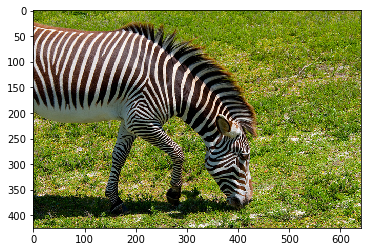

In [16]:
show_image(idx=3, train=True)

In [17]:
image_model =VGG16(include_top=True, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
# image_model= ResNet50(include_top=True, weights='imagenet')

In [19]:
# image_model= InceptionV3(include_top=True, weights='imagenet')

In [20]:
# use vgg16
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
# use Inception V3
# transfer_layer = image_model.get_layer('avg_pool')

In [22]:
#use Resnet 50
# transfer_layer = image_model.get_layer('flatten')

In [23]:
#use VGG16
transfer_layer = image_model.get_layer('fc2')

In [24]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [25]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [26]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

In [27]:
def print_progress(count, max_count):

    pct_complete = count / max_count

    msg = "\r- Progress: {0:.1%}".format(pct_complete)


    sys.stdout.write(msg)
    sys.stdout.flush()

In [28]:
def process_images(data_dir, filenames, batch_size=32):

    num_images = len(filenames)

    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    start_index = 0

    while start_index < num_images:

        print_progress(count=start_index, max_count=num_images)

        end_index = start_index + batch_size

        if end_index > num_images:
            end_index = num_images

        current_batch_size = end_index - start_index

        for i, filename in enumerate(filenames[start_index:end_index]):

            path = os.path.join(data_dir, filename)


            img = load_image(path, size=img_size)

            image_batch[i] = img

        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        start_index = end_index


    print()

    return transfer_values

In [29]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")


    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

In [30]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))


    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

In [31]:

import os

base_path = "/scratch/data/"
filename = "transfer_values_train.pkl"
path_to_file = os.path.join(base_path, filename)
transfer_values_train =open(path_to_file )


In [32]:
%%time
import sys
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: /scratch/data/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
CPU times: user 227 ms, sys: 661 ms, total: 888 ms
Wall time: 886 ms


In [33]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: /scratch/data/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
CPU times: user 10 ms, sys: 33 ms, total: 43 ms
Wall time: 41.9 ms


In [34]:
mark_start = 'ssss '
mark_end = ' eeee'

In [35]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [ ]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

In [37]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

In [38]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [39]:
captions_train_flat = flatten(captions_train_marked)

In [40]:
num_words = 10000

In [41]:
class TokenizerWrap(Tokenizer):

    
    def __init__(self, texts, num_words=None):


        Tokenizer.__init__(self, num_words=num_words)


        self.fit_on_texts(texts)


        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):


        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):

        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]

        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):

        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [46]:
captions_train_flat

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee',
 'ssss A giraffe eating food from the top of the tree. eeee',
 'ssss A giraffe standing up nearby a tree  eeee',
 'ssss A giraffe mother with its baby in the forest. eeee',
 'ssss Two giraffes standing in a tree filled area. eeee',
 'ssss A giraffe standing next to a forest filled with trees. eeee',
 'ssss A flower vase is sitting on a porch stand. eeee',
 'ssss White vase with different colored flowers sitting inside of it.  eeee',
 'ssss a white vase with many flowers on a stage eeee',
 'ssss A white vase filled with different colored flowers. eeee',
 'ssss A vase with red and white flowers outside on a sunny day. eeee',
 'ssss A zebra grazing on 

In [47]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 9.34 s, sys: 0 ns, total: 9.34 s
Wall time: 9.34 s


In [49]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [50]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [51]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 8.63 s, sys: 54.4 ms, total: 8.68 s
Wall time: 8.68 s


In [52]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [53]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [54]:
def get_random_caption_tokens(idx):
    

    result = []


    for i in idx:

        j = np.random.choice(len(tokens_train[i]))


        tokens = tokens_train[i][j]

        result.append(tokens)

    return result

In [55]:
tokens_train[12][1]

[2, 45, 5981, 50, 1, 230, 4, 6, 512, 5, 1, 2251, 23, 3]

In [56]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

   
    while True:
        
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        

        transfer_values = transfer_values_train[idx]


        tokens = get_random_caption_tokens(idx)


        num_tokens = [len(t) for t in tokens]
        

        max_tokens = np.max(num_tokens)
        


        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
    
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

 
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [57]:

batch_size = 100

In [58]:
generator = batch_generator(batch_size=batch_size)

In [59]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [60]:
transfer_values_train

array([[0.    , 0.    , 1.378 , ..., 0.    , 0.    , 0.5244],
       [0.    , 0.    , 1.268 , ..., 0.    , 0.    , 0.461 ],
       [0.    , 0.    , 1.617 , ..., 0.    , 0.    , 0.533 ],
       ...,
       [0.    , 0.    , 1.162 , ..., 0.    , 0.    , 0.6055],
       [0.    , 0.    , 1.539 , ..., 0.    , 0.    , 0.7695],
       [0.    , 0.    , 1.167 , ..., 0.    , 0.    , 0.6646]],
      dtype=float16)

In [61]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.592, ..., 0.   , 0.   , 0.748], dtype=float16)

In [62]:
batch_x['decoder_input'][0].size

25

In [63]:
batch_y['decoder_output'][0].size

25

In [64]:
tf.convert_to_tensor(batch_x['decoder_input'])

<tf.Tensor 'Const:0' shape=(100, 25) dtype=int32>

In [65]:
tf.convert_to_tensor((batch_x['decoder_input']))

<tf.Tensor 'Const_1:0' shape=(100, 25) dtype=int32>

In [66]:
num_captions_train = [len(captions) for captions in captions_train]

In [67]:
total_num_captions_train = np.sum(num_captions_train)

In [68]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

5917

In [69]:
state_size = 512

In [70]:
embedding_size = 128

In [71]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [72]:
transfer_values_size

4096

In [73]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [74]:
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_input.get_shape()

TensorShape([Dimension(None), Dimension(None)])

In [75]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [76]:
decoder_embedding

In [77]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [78]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [79]:
def connect_decoder(transfer_values):

    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input

    net = decoder_embedding(net)
    

    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    decoder_output = decoder_dense(net)
    
    return decoder_output

In [80]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, ?) dtype=float32>

In [81]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [82]:
decoder_output 

<tf.Tensor 'decoder_output/BiasAdd:0' shape=(?, ?, 10000) dtype=float32>

In [83]:
batch_y['decoder_output'].shape

(100, 25)

In [84]:
batch_x['decoder_input'].shape

(100, 25)

In [86]:
def sparse_cross_entropy(y_true, y_pred):

    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [87]:
optimizer = RMSprop(lr=1e-3)

In [88]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [89]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [90]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [91]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [92]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [93]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [94]:
generator

<generator object batch_generator at 0x7ff880463620>

In [95]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          2097664     transfer_values_input[0][0]      
__________________________________________________________________________________________________
decoder_gr

In [96]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=1,
                            callbacks=callbacks)

5916/5917 [============================>.] - ETA: 0s - loss: 1.4593
Epoch 00001: saving model to 22_checkpoint.keras
5917/5917 [==============================] - 3803s 643ms/step - loss: 1.4593
CPU times: user 16h 24min 59s, sys: 17min 15s, total: 16h 42min 15s
Wall time: 1h 3min 25s


In [90]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

   
    image = load_image(image_path, size=img_size)
    
   
    image_batch = np.expand_dims(image, axis=0)

    transfer_values = image_model_transfer.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = token_start


    output_text = ''


    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:

        decoder_input_data[0, count_tokens] = token_int


        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        decoder_output = decoder_model.predict(x_data)

        token_onehot = decoder_output[0, count_tokens, :]

        token_int = np.argmax(token_onehot)


        sampled_word = tokenizer.token_to_word(token_int)


        output_text += " " + sampled_word

        count_tokens += 1


    output_tokens = decoder_input_data[0]


    plt.imshow(image)
    plt.show()
    

    print("Predicted caption:")
    print(output_text)
    print()
    return output_text

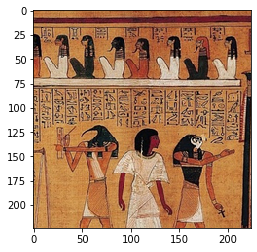

Predicted caption:
 a man standing in a room holding a remote eeee



' a man standing in a room holding a remote eeee'

In [91]:
generate_caption("images/style4.jpg")

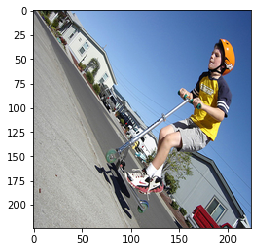

Predicted caption:
 a man riding a snowboard down a snow covered slope eeee



' a man riding a snowboard down a snow covered slope eeee'

In [92]:
generate_caption("images/a.jpg")

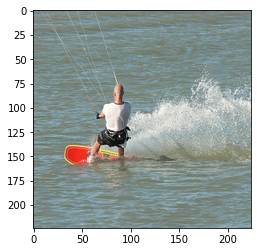

Predicted caption:
 a man riding a wave on top of a surfboard eeee



' a man riding a wave on top of a surfboard eeee'

In [93]:
generate_caption("images/d.jpg")

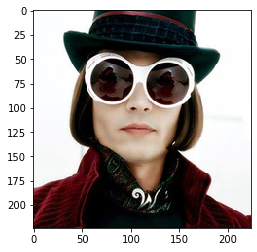

Predicted caption:
 a man wearing a suit and tie standing next to a window eeee



In [94]:
a=generate_caption("images/willy_wonka_new.jpg")

In [96]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:

        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:

        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(data_dir, filename)

    output_text=generate_caption(image_path=path)
  

    print("True captions:")
    for caption in captions:
        print(caption)
        
    return output_text,captions

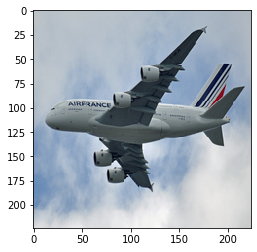

Predicted caption:
 a large commercial plane flying in the sky eeee

True captions:
A big airplane flying in the big blue sky
Large, two decked, four engined airliner in flight.
An AirFrance jet airplane flying in the sky 
A big plane with AirFrance on the side of it.
An Air France air plane in mid flight.


In [97]:
[Predicted_caption,True_captions]=generate_caption_coco(idx=15, train=True)

In [98]:
filenames_train[15]

'000000000081.jpg'

In [99]:
candidate=Predicted_caption.split()
candidate

['a', 'large', 'commercial', 'plane', 'flying', 'in', 'the', 'sky', 'eeee']

In [100]:
candidate=['a',
 'plane',
 'flying',
 'in',
 'the',
 'sky',
 'with',
 'a',
 'lot',
 'of',
 'smoke',
 'eeee']
reference=[['A', 'big', 'airplane', 'flying', 'in', 'the', 'big', 'blue', 'sky'],
 ['Large,', 'two', 'decked,', 'four', 'engined', 'airliner', 'in', 'flight.'],
 ['An', 'AirFrance', 'jet', 'airplane', 'flying', 'in', 'the', 'sky'],
 ['A', 'big', 'plane', 'with', 'AirFrance', 'on', 'the', 'side', 'of', 'it.'],
 ['An', 'Air', 'France', 'air', 'plane', 'in', 'mid', 'flight.']]


In [101]:
reference=[]
for caption in True_captions:
    reference.append(caption.split())
reference
    

[['A', 'big', 'airplane', 'flying', 'in', 'the', 'big', 'blue', 'sky'],
 ['Large,', 'two', 'decked,', 'four', 'engined', 'airliner', 'in', 'flight.'],
 ['An', 'AirFrance', 'jet', 'airplane', 'flying', 'in', 'the', 'sky'],
 ['A', 'big', 'plane', 'with', 'AirFrance', 'on', 'the', 'side', 'of', 'it.'],
 ['An', 'Air', 'France', 'air', 'plane', 'in', 'mid', 'flight.']]

# EVALUATE Bleu-1,2,3,4 Metric

In [102]:
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu
# score=sentence_bleu(reference,candidate)
chencherry = SmoothingFunction()
print('Cumulative bleu-1: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=chencherry.method4))
print('Cumulative bleu-2: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method4))
print('Cumulative bleu=3: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=chencherry.method4))
print('Cumulative bleu-4: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method4))

Cumulative bleu-1: 0.583333
Cumulative bleu-2: 0.398862
Cumulative bleu=3: 0.320540
Cumulative bleu-4: 0.243842


In [103]:
from nltk.translate.bleu_score import sentence_bleu
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.583333
Cumulative 2-gram: 0.398862
Cumulative 3-gram: 0.320540
Cumulative 4-gram: 0.243842


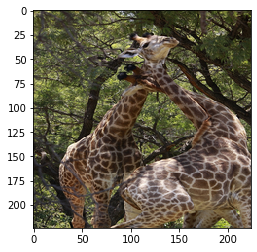

Predicted caption:
 a giraffe standing in a field of tall grass eeee

True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


(' a giraffe standing in a field of tall grass eeee',
 ['A couple of giraffe snuggling each other in a forest.',
  'A couple of giraffe standing next to some trees.',
  'Two Zebras seem to be embracing in the wild. ',
  'Two giraffes hang out near trees and nuzzle up to each other.',
  'The two giraffes appear to be hugging each other.'])

In [104]:
generate_caption_coco(idx=10, train=True)

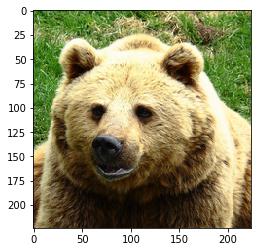

Predicted caption:
 a brown and white dog laying on a bed with a white blanket eeee

True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


(' a brown and white dog laying on a bed with a white blanket eeee',
 ['A big burly grizzly bear is show with grass in the background.',
  'The large brown bear has a black nose.',
  'Closeup of a brown bear sitting in a grassy area.',
  'A large bear that is sitting on grass. ',
  "A close up picture of a brown bear's face."])

In [105]:
generate_caption_coco(idx=1, train=False)